# Measurement and verification

The ability to predict energy demand can be valued in the context of Measurement and Verification (M&V). M&V is the process of assessing savings caused by an Energy Conservation Measure (ECM). Savings are determined by comparing measured consumption or demand before and after implementation of a program, making suitable adjustments for changes in conditions.

<img src='images/mv.png' width=600 />

An example of adjustment is, when estimating the energy savings delivered by an ECM, to substract its new energy consumption from the consumption that would have occurred if the building had stayed in the same situation in the weather conditions of the reporting period (adjusted baseline consumption). This requires a prediction model that can extrapolate the initial behaviour of the building by accounting for variable weather conditions. Other possible adjustments include changes in occupancy schedules. This is necessary to assess whether measured energy savings are caused by the ECM itself, or by changes in these influences.

## Data

A commercial building has been monitored for three years. We have measurements of its daily electricity consumption and outdoor temperature.

An energy conservation measure has been done after the first year. We want to calculate the energy savings made thanks to this measure.

The following blok reads the data for the first year.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# Importing data into a dataframe with the pandas library
df = pd.read_excel('data/building6.xlsx')
df.set_index(pd.to_datetime(df['date']), inplace=True)
# Filtering out weekends
df = df[df['dayofweek'] < 5]
# This line shows the first few lines of the dataset
df.head()

,date,Temperature,Power kW,dayofweek
date,,,,
2009-01-02,2009-01-02,0.942130,865.3,4
2009-01-05,2009-01-05,12.231481,821.4,0
2009-01-06,2009-01-06,24.275463,1090.2,1
2009-01-07,2009-01-07,23.053241,1068.4,2
2009-01-08,2009-01-08,30.738426,728.5,3


<AxesSubplot:xlabel='Temperature', ylabel='Power kW'>

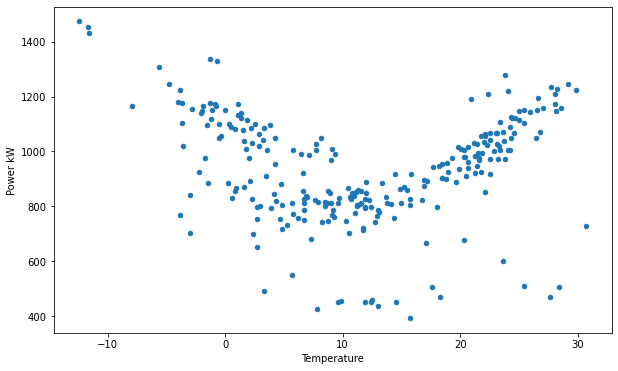

In [2]:
df.plot.scatter(x = 'Temperature',
                y = 'Power kW',
                figsize = [10, 6])

## Fitting a baseline model

After looking at the data, we can suggest using a change-point model which will include the effects of heating and cooling, and separate week ends from working days. The expected daily energy use $E$ (in kWh per day) is a function of the outdoor temperature $T$ and of a number of parameters:

$$E(T) = \alpha + \beta_{h}(\tau_{h}-T)^+ + \beta_{c}(T-\tau_{c})^+ + \varepsilon$$

We define this model as a Python function which takes the temperature $T$ as input and 5 parameters $(\alpha, \beta_h, \beta_c, \tau_h, \tau_c)$.

In [3]:
def signature(T, alpha, beta_h, beta_c, tau_h, tau_c):
    E = alpha * np.ones_like(T)

    mask1 = T < tau_h
    E[mask1] += beta_h * (tau_h-T[mask1])

    mask2 = T > tau_c
    E[mask2] += beta_c * (T[mask2]-tau_c)

    return E

Next we use the curve fitting function to find the parameters with which the model best matches the data.

In [4]:
popt, pcov = curve_fit(signature,
                       xdata = df['Temperature'],
                       ydata = df['Power kW'],
                       p0 = [800, 60, 60, 5, 15])

# Saving results into a dataframe and displaying it
res1 = pd.DataFrame(index=['alpha', 'beta_h', 'beta_c', 'tau_h', 'tau_c'])
res1['avg'] = popt
res1['std'] = np.diag(pcov)**0.5
print(res1)

               avg        std
alpha   783.844583  19.765942
beta_h   32.023805   3.777809
beta_c   23.307880   3.743958
tau_h     7.506575   1.082617
tau_c    14.000506   1.641179


Prediction of the energy consumption by the model and comparison with the data

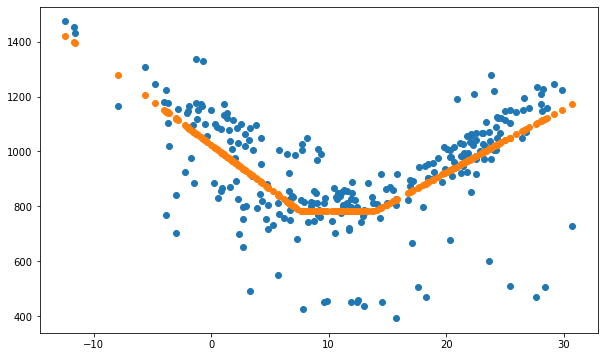

In [5]:
E_pred = signature(df['Temperature'], *popt)

fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(df['Temperature'], df['Power kW'])
ax.scatter(df['Temperature'], E_pred)

Comparison of the total energy consumption: measured vs. predicted by the model

In [12]:
print("Measured (kWh): ", np.sum(df['Power kW']))
print("Predicted (kWh): ", np.sum(E_pred))

Measured (kWh):  242259.53043478224
Predicted (kWh):  242259.53043385647


## Comparison with the consumption after the energy conservation measure

We can now load the measured energy of the second and third years into new dataframes.

In [6]:
# Data of the second year
df2 = pd.read_excel('data/building6.xlsx', sheet_name='During')
df2.set_index(pd.to_datetime(df2['date']), inplace=True)
df2 = df2[df2['dayofweek'] < 5]

# Data of the third year
df3 = pd.read_excel('data/building6.xlsx', sheet_name='Post')
df3.set_index(pd.to_datetime(df3['date']), inplace=True)
df3 = df3[df3['dayofweek'] < 5]

Question: calculate the energy savings due to the energy conservation measure performed after year 1, by comparing model predictions with measurements.